### Loading Libraries

In [ ]:
# Downgrade protobuf to avoid TypeError
# %pip install protobuf==3.20.*

   ---------------------------------------- 0.0/904.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.4 kB ? eta -:--:--
   ---------------------------------------- 0.0/904.4 kB ? eta -:--:--
   ----------- ---------------------------- 262.1/904.4 kB ? eta -:--:--
   ----------------------- ---------------- 524.3/904.4 kB 1.4 MB/s eta 0:00:01
   ---------------------------------------- 904.4/904.4 kB 1.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.28.3
    Uninstalling protobuf-5.28.3:
      Successfully uninstalled protobuf-5.28.3
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [1]:
!pip install kagglehub

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import random
import os
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import xception
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [3]:
pd.options.display.max_rows = 100

### Brief Exploration

In [8]:
import kagglehub
import shutil
import os

# Download latest version
path = kagglehub.dataset_download("shivajbd/analog-clocks")

# Destination directory
destination_dir = '/content/analog-clocks'

# Create the destination directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Copy the downloaded dataset to the destination directory
# The dirs_exist_ok=True argument allows copying into an existing directory
shutil.copytree(path, destination_dir, dirs_exist_ok=True)

print("Dataset copied to:", destination_dir)

Dataset copied to: /content/analog-clocks


In [34]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [47]:
#defining directory paths
image_dir = '/content/analog-clocks/analog_clocks/images' # Add /content
labels_dir = '/content/analog-clocks/analog_clocks/label.csv' # Add /content

In [28]:
!pwd

/content


In [29]:
#examining labels
labels = pd.read_csv(labels_dir)
labels.head()

,hour,minute
0,4,2
1,9,44
2,3,6
3,3,30
4,2,3


In [30]:
labels.describe()

,hour,minute
count,50000.000000,50000.000000
mean,5.522940,29.531240
std,3.459953,17.210759
min,0.000000,0.000000
25%,3.000000,15.000000
50%,6.000000,30.000000
75%,9.000000,44.000000
max,11.000000,59.000000


In [31]:
#distribution of classes in hour column
labels.hour.value_counts(normalize=True)

,proportion
hour,
8,0.08580
11,0.08546
6,0.08462
10,0.08452
1,0.08428
2,0.08290
7,0.08286
3,0.08248
0,0.08246


In [32]:
#distribution of classes in minute column
labels.minute.value_counts(normalize=True)

,proportion
minute,
37,0.01804
19,0.01790
39,0.01778
32,0.01776
44,0.01774
45,0.01744
13,0.01744
28,0.01736
17,0.01734


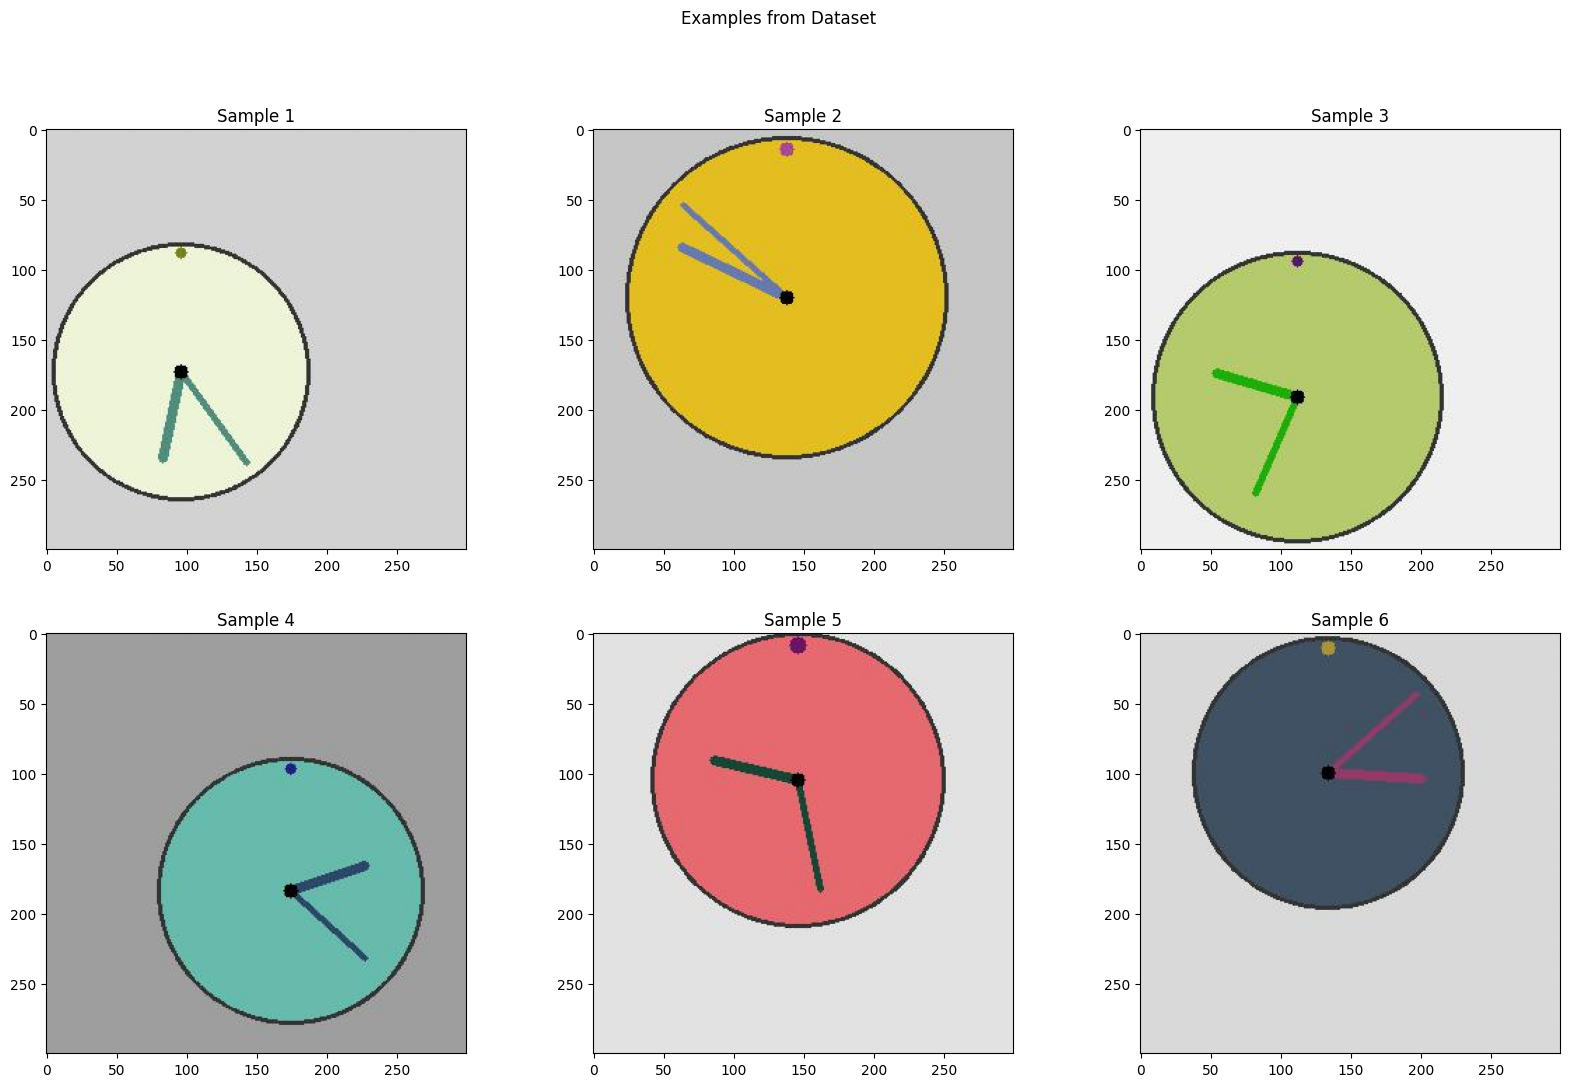

In [36]:
#preview of dataset
sample_dir = '/content/analog-clocks/analog_clocks/samples'
fig = plt.figure(figsize=(20, 12))
plt.suptitle('Examples from Dataset')
for i, file in enumerate(os.listdir(sample_dir)):
    img = image.load_img(os.path.join(sample_dir, file),
                         interpolation='box')
    img = image.img_to_array(img, dtype='float32')
    img /= 255.0
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title('Sample ' + str(i+1))

### Data Processing

In [38]:
#transforming labels to multi-label binary format
labels_df = pd.read_csv(labels_dir)
labels_df['tuples'] = [tuple(x) for x in labels_df.values]
labels_df['tuples'] = [('h' + str(x), 'm' + str(y)) for x,y in labels_df['tuples'].values]
labels_df = labels_df.drop(columns=['hour', 'minute'])
# labels_df = labels_df.reset_index()
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(labels_df['tuples'])

In [39]:
#preview of dataframe
labels_df.head()

,tuples
0,"(h4, m2)"
1,"(h9, m44)"
2,"(h3, m6)"
3,"(h3, m30)"
4,"(h2, m3)"


In [40]:
#distribution of unique labels
labels_df['tuples'].value_counts()

,count
tuples,
"(h7, m22)",94
"(h4, m4)",94
"(h10, m48)",93
"(h6, m32)",92
"(h1, m24)",92
...,...
"(h6, m27)",48
"(h9, m48)",47
"(h9, m7)",47


In [41]:
#creating train-test split
train, test = train_test_split(labels_df,
                               stratify=labels_df['tuples'],
                               test_size=0.20,
                               random_state=42
                              )

train_idx, test_idx = list(train.index), list(test.index)

In [42]:
train_idx[:10]

[47020, 43132, 16667, 4469, 31729, 47257, 3150, 265, 37534, 17202]

In [43]:
test_idx[:10]

[43982, 7336, 28536, 23839, 20476, 17705, 29716, 18797, 27445, 900]

In [44]:
def generate(image_directory, labels, train_idx=None, batch_size=64, size=(224, 224)):

    """
    Function to create generator of images and labels for the neural network. This allows for training
    the model with the limited memory available. The images and labels are generated in batches of a given size.
    The images are loaded, added to a batch, preprocessed and have their features extracted using a prebuilt model
    (in this case Xception Model).

    Parameters
    ----------
    image_directory: str
        The path where the images are located
    labels: array-like or list
        list of labels in multi-label binary format
    batch_size: int, default=64
        the number of images per batch
    size: tuple, default=(224, 224)
        the height and width to which the image is resized.

    Yields
    ------
    image_batch: array
        Array of image features of size=batch_size
    labels_batch: array
        Array of labels in multi-label binary format of size=batch_size

    """


    prebuilt_model = xception.Xception(include_top=True,
              weights='imagenet')                                            #loading prebuilt model

    xception_model = Model(inputs=prebuilt_model.input,
                           outputs=prebuilt_model.layers[-2].output)         #repurposing prebuilt model for feature extraction



    while 1:

        if train_idx==None:
            image_filenames = os.listdir(image_directory)                    #obtaining list of image filenames
        else:
            image_filenames = [str(idx) + '.jpg' for idx in train_idx]

        random.shuffle(image_filenames)                                      #shuffling the list to add randomness every epoch


        image_batch = []                                                     #initializing empty image batch list
        labels_batch = []                                                    #initializing empty labels batch list

        for file in image_filenames:                                         #looping over all images in directory

            index = int(file.split('.')[0])                                  #extracting image number/index from filename

            img = image.load_img(os.path.join(image_directory, file),        #loading image
                                 target_size=size,
                                 interpolation='box')

            img_arr = image.img_to_array(img, dtype='float32')               #converting image to array

            label = labels[index]                                            #using image number/index to find correct label in dataframe

            image_batch.append(img_arr)                                      #appending the image to the batch
            labels_batch.append(label)                                       #appending the label to the batch


            if len(image_batch)==batch_size:                                 #check to see if batch has required size
                image_batch = np.array(image_batch)                          #converting image batch list to array
                image_batch = xception.preprocess_input(image_batch)         #using xception preprocessing on image batch array
                image_features = xception_model.predict(image_batch)         #using prebuilt xception model to extract features from batch
                image_batch = np.array(image_features)                       #converting features to array
                image_batch = image_batch.reshape(batch_size,                #reshaping feature array
                                                  image_features.shape[1])
                labels_batch = np.array(labels_batch)                        #converting labels batch list to array
                yield image_batch, labels_batch                              #yielding image and labels batch array
                image_batch = []                                             #reinitializing the image batch
                labels_batch = []                                            #reinitializing the label batch
                gc.collect()                                                 #collecting garbage to free memory


In [45]:
#Defining training parameters
BATCH_SIZE = 256
IMAGE_SIZE = (299, 299) #this is the size suggested for Xception model
EPOCHS = 10
STEPS = int(len(train_idx) / BATCH_SIZE)

In [48]:
#testing generator
sample_generator = next(generate(image_directory=image_dir,
                                 labels=y,
                                 train_idx=train_idx,
                                 batch_size=1,
                                 size=IMAGE_SIZE))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


In [49]:
#output of generator
sample_generator

(array([[0.        , 0.        , 0.        , ..., 0.00228632, 0.255296  ,
         0.22508697]], dtype=float32),
 array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]))

In [50]:
#extracting input and output dims from generator
INPUT_DIM = sample_generator[0][0].shape
OUTPUT_DIM = sample_generator[1].shape[1]

In [51]:
print(INPUT_DIM, OUTPUT_DIM)

(2048,) 72


In [52]:
def create_model(input_shape, output_shape):

    """
    Function to build and compile neural network to predict analog clocks from images

    Parameters
    ----------
    input_shape: tuple
        Shape tuple not including the batch_size, example: (2048, )
    output_shape: int
        Number of nodes in final layer

    Returns
    -------
    model: Keras model object
        A compiled Keras model
    """

    input_layer = Input(shape=input_shape)
    norm  = BatchNormalization()(input_layer)
    drop = Dropout(0.25)(norm)
    fc1 = Dense(256, activation='relu')(norm)
    fc2 = Dense(256, activation='relu')(fc1)
    output1 = Dense(output_shape, activation='sigmoid')(fc2)

    #contructing model from layers
    model = Model(inputs=input_layer,
                  outputs=output1)

    #compiling model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
                  )

    return model

In [53]:
#creating instance of model
model = create_model(input_shape=INPUT_DIM,
                     output_shape=OUTPUT_DIM)

In [54]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 72)                  │          18,504 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 617,032 (2.35 MB)

 Trainable params: 612,936 (2.34 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [55]:
#initializing generator for training
generator = generate(image_directory=image_dir,
                     labels=y,
                     train_idx=train_idx,
                     batch_size=BATCH_SIZE,
                     size=IMAGE_SIZE)

In [56]:
#fitting model
history = model.fit(generator,
                    epochs=EPOCHS,
                    steps_per_epoch=STEPS)

8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 189ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 203ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 206ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 203ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 201ms/step
8/8 ━━━━━━━━━

### Model Prediction on Sample

In [57]:
def predict(image_directory, indices=None, plot=False):

    """
    Function to predict all images in a given path

    Parameters
    ----------
    image_directory: str
        Path for images to be predicted
    indices: list, default = None
        Indices corresponding to image labels to predict
    plot: boolean, default=False
        Whether or not to create plot of predictions

    Returns
    -------
    predictions_list: list
        List of predictions corresponding to the images
    """

    images_list = []

    prebuilt_model = xception.Xception(include_top=True,
                                       weights='imagenet')           #loading pre-built model

    xception_model = Model(inputs=prebuilt_model.input,
                           outputs=prebuilt_model.layers[-2].output) #repurposing pre-built model for feature extraction

    if indices!=None:
        image_filenames = [str(idx) + '.jpg' for idx in indices]
    else:
        image_filenames = os.listdir(image_directory)

    if plot:
        dim = int(np.ceil(np.sqrt(len(image_filenames))))
        fig, axs = plt.subplots(nrows=dim,
                                ncols=dim,
                                figsize=(20, 14))
        plt.suptitle('Example of Model Predictions', fontsize=32)

#         axs = axs.flatten()


    #looping over all images in path
    for i, file in enumerate(image_filenames):


        img = image.load_img(os.path.join(image_directory,
                                          file))                     #loading images
        img_arr = image.img_to_array(img, dtype='float32')           #converting images to array

        if plot:
            axs.flat[i].imshow(img_arr/255.0)

        images_list.append(img_arr)
        gc.collect()

    print('preprocessing...')
    images_list = np.array(images_list)
    img_arr = xception.preprocess_input(images_list)                 #preprocessing image array using xception method
    print('extracting features...')
    img_features = xception_model.predict(img_arr)                   #extracting features from image using prebuilt xception model
    img_features = np.array(img_features)
    print('predicting...')
    prediction = model.predict(img_features)                         #predicting time from image features
    hour_max = np.argmax(prediction[:, :12], axis=1)                 #obtaining hour with the highest probability
    minute_max = np.argmax(prediction[:, 12:], axis=1) + 12          #obtaining minute with the highest probability
    prediction_list = [(binarizer.classes_[x],                       #getting labels for predictions for binarizer
                        binarizer.classes_[y])
                        for (x,y) in list(zip(hour_max, minute_max))]

    if plot:                                                         #setting title for plots
        for i, v in enumerate(prediction_list):
            axs.flat[i].set_title(str(v[0]) + ' ' + str(v[1]))
            axs.flat[i].axis('off')
        for j in range(i+1, dim**2):                                 #removing excess subplots
              fig.delaxes(axs.flat[j])

    return prediction_list


In [65]:
def predict(image_directory, indices=None, plot=False):
    """
    Function to predict all images in a given path

    Parameters
    ----------
    image_directory: str
        Path for images to be predicted
    indices: list, default = None
        Indices corresponding to image labels to predict
    plot: boolean, default=False
        Whether or not to create plot of predictions

    Returns
    -------
    predictions_list: list
        List of predictions corresponding to the images
    """
    images_list = []

    # Load prebuilt Xception model
    prebuilt_model = xception.Xception(include_top=True,
                                       weights='imagenet')

    # Repurpose the prebuilt model for feature extraction
    xception_model = Model(inputs=prebuilt_model.input,
                           outputs=prebuilt_model.layers[-2].output)

    # Prepare image filenames
    if indices is not None:
        image_filenames = [str(idx) + '.jpg' for idx in indices]
    else:
        image_filenames = os.listdir(image_directory)

    if plot:
        dim = int(np.ceil(np.sqrt(len(image_filenames))))
        fig, axs = plt.subplots(nrows=dim,
                                ncols=dim,
                                figsize=(20, 14))
        plt.suptitle('Example of Model Predictions', fontsize=32)

    # Loop through all images
    for i, file in enumerate(image_filenames):
        # Load and resize image
        img = image.load_img(os.path.join(image_directory, file), target_size=(299, 299))
        img_arr = image.img_to_array(img, dtype='float32')  # Convert image to array

        if plot:
            axs.flat[i].imshow(img_arr / 255.0)  # Normalize for visualization

        images_list.append(img_arr)
        gc.collect()

    print('preprocessing...')
    images_list = np.array(images_list)
    img_arr = xception.preprocess_input(images_list)  # Preprocess images using Xception method

    print('extracting features...')
    img_features = xception_model.predict(img_arr)  # Extract features using prebuilt Xception model
    img_features = np.array(img_features)

    print('predicting...')
    prediction = model.predict(img_features)  # Predict time from image features
    hour_max = np.argmax(prediction[:, :12], axis=1)  # Get hour with the highest probability
    minute_max = np.argmax(prediction[:, 12:], axis=1) + 12  # Get minute with the highest probability

    # Map predictions to labels
    prediction_list = [
        (binarizer.classes_[x], binarizer.classes_[y])
        for (x, y) in zip(hour_max, minute_max)
    ]

    # Plot predictions if required
    if plot:
        for i, v in enumerate(prediction_list):
            axs.flat[i].set_title(f"{v[0]} {v[1]}")
            axs.flat[i].axis('off')
        for j in range(i + 1, dim**2):  # Remove excess subplots
            fig.delaxes(axs.flat[j])

    return prediction_list

preprocessing...
extracting features...
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
predicting...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step


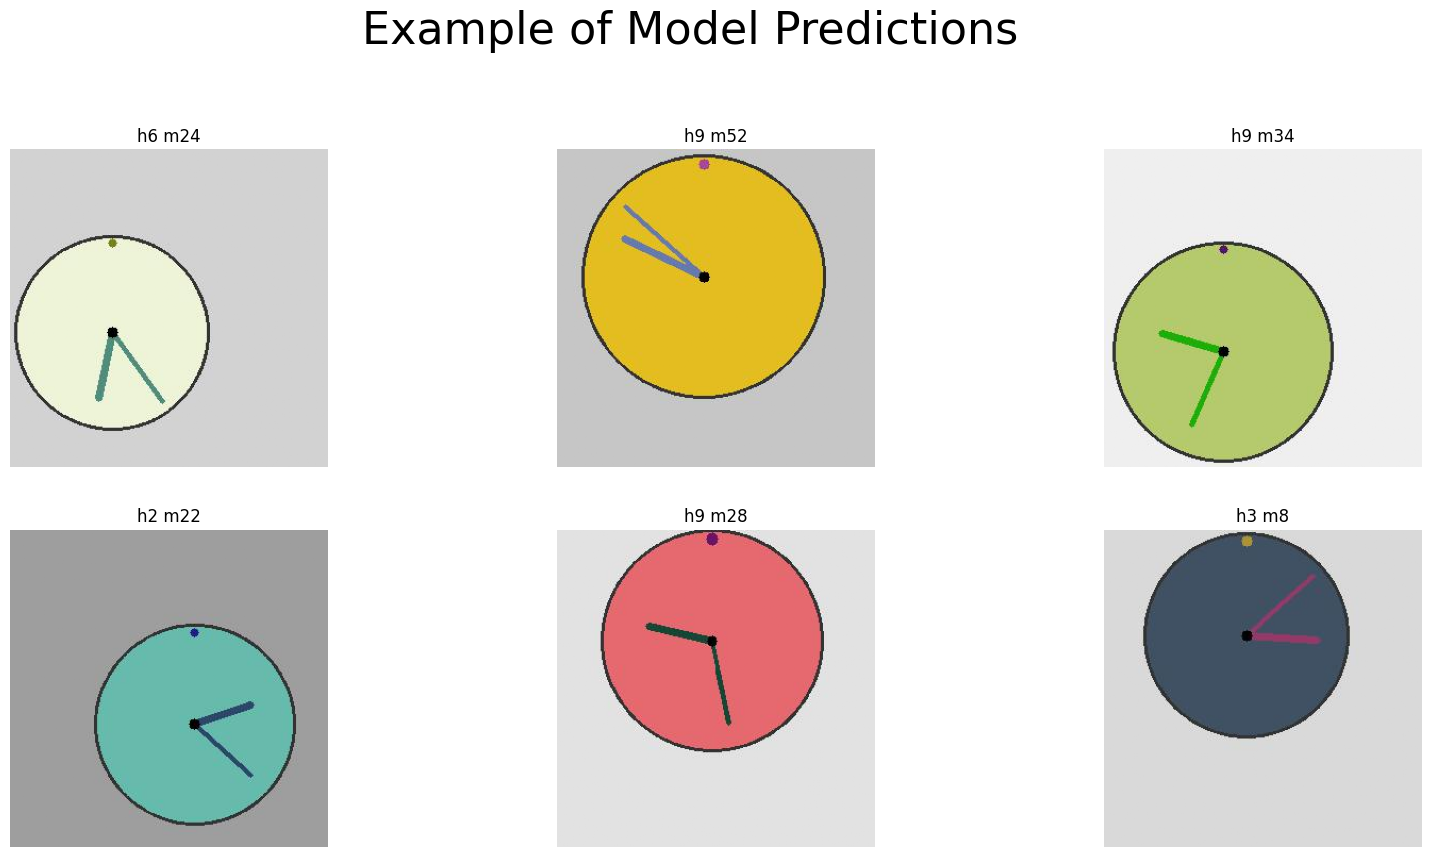

In [66]:
# predicting samples used in earlier vizualization
predictions = predict('/content/analog-clocks/analog_clocks/samples/', plot=True)

In [67]:
#taking sample of test set to visualize results on unseen data
#this is done due to memory limitations
SIZE = 64
sample_test = list(np.random.choice(test_idx, size=SIZE))

preprocessing...
extracting features...
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 241ms/step
predicting...


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step  


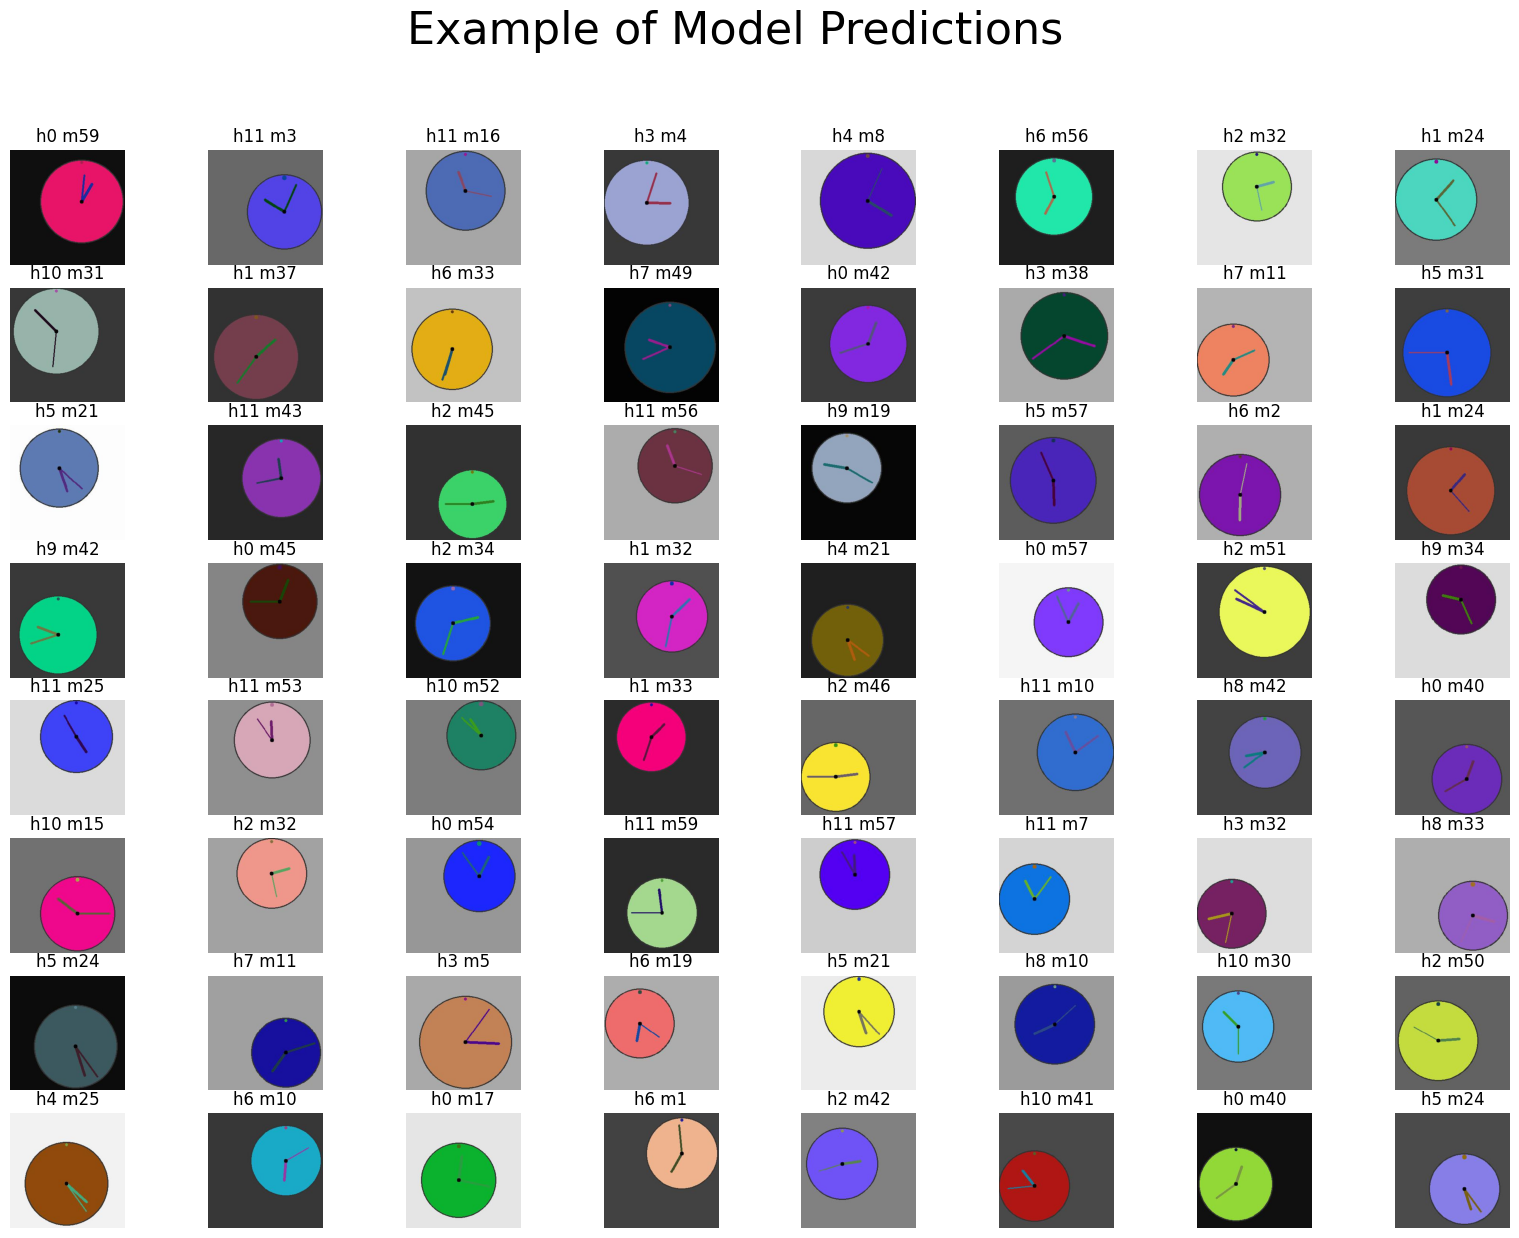

In [69]:
#predicting sample of test set
predictions = predict('/content/analog-clocks/analog_clocks/images',
                        indices=sample_test,
                        plot=True)

In [70]:
sample_results = pd.DataFrame(list(zip(labels_df.loc[sample_test]['tuples'].values, pd.Series(predictions))), columns=['Actual', 'Predicted'])
sample_results

,Actual,Predicted
0,"(h1, m1)","(h0, m59)"
1,"(h10, m4)","(h11, m3)"
2,"(h11, m17)","(h11, m16)"
3,"(h3, m3)","(h3, m4)"
4,"(h4, m4)","(h4, m8)"
5,"(h6, m57)","(h6, m56)"
6,"(h2, m28)","(h2, m32)"
7,"(h1, m24)","(h1, m24)"
8,"(h10, m31)","(h10, m31)"
9,"(h1, m36)","(h1, m37)"


In [72]:
# Set layers to non-trainable
for layer in model.layers:
    layer.trainable = False

# Save model in Keras format
model.save('model.keras')


In [73]:
# Set layers to non-trainable
for layer in model.layers:
    layer.trainable = False

# Save model in HDF5 format
model.save('model.h5')

In [75]:
import tensorflow as tf

# Set layers to non-trainable
for layer in model.layers:
    layer.trainable = False

# Save the model as a TensorFlow SavedModel
tf.saved_model.save(model, 'model_directory')  # Ensure 'model_directory' doesn't exist already

In [76]:
import shutil

# Path to the directory you want to zip
directory_to_zip = 'model_directory'

# Output ZIP file name
output_zip_file = 'model_directory.zip'

# Zip the directory
shutil.make_archive(base_name=output_zip_file.replace('.zip', ''),
                    format='zip',
                    root_dir=directory_to_zip)

print(f"Directory '{directory_to_zip}' has been zipped into '{output_zip_file}'")

Directory 'model_directory' has been zipped into 'model_directory.zip'


In [77]:
from google.colab import files

# Download the ZIP file
files.download('model_directory.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Take Aways

- Prebuilt models are very useful to extract features in this case
- Treating this problem as a multi-label classification achieves the best results over multi-class, possible due to lower dimensionality of labels (72 verus 720)
    - Initially tried having two outputs to the model, one for hours and one for minutes, but the model prioritizes optimizing hours over minutes
- Model performs well on unseen data
    - Since hours have less categories (12) their prediction is generally more accurate than the minutes (60)
    - The errors made by the model are reasonable
    - Since there are no minute-marker ticks on the clocks, even human eye can struggle to tell exact minute